In [1]:
# Preparing the notebook by importing necessary modules
import acquire
import prepare
from sklearn.model_selection import train_test_split


from sklearn.metrics import mean_squared_error, explained_variance_score
from scipy import stats
from math import sqrt
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# Acquire 

In [2]:
df= acquire.get_zillow_data()
df.shape

(28073, 11)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28073 entries, 0 to 28072
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Unnamed: 0                    28073 non-null  int64  
 1   parcelid                      28073 non-null  int64  
 2   fips                          28073 non-null  float64
 3   latitude                      28073 non-null  float64
 4   longitude                     28073 non-null  float64
 5   lotsizesquarefeet             27876 non-null  float64
 6   calculatedfinishedsquarefeet  28070 non-null  float64
 7   bedroomcnt                    28073 non-null  float64
 8   bathroomcnt                   28073 non-null  float64
 9   taxamount                     28072 non-null  float64
 10  taxvaluedollarcnt             28072 non-null  float64
dtypes: float64(9), int64(2)
memory usage: 2.4 MB


In [4]:
df.describe()

,Unnamed: 0,parcelid,fips,latitude,longitude,lotsizesquarefeet,calculatedfinishedsquarefeet,bedroomcnt,bathroomcnt,taxamount,taxvaluedollarcnt
count,28073.00000,2.807300e+04,28073.000000,2.807300e+04,2.807300e+04,2.787600e+04,28070.000000,28073.000000,28073.000000,28072.000000,2.807200e+04
mean,14036.00000,1.303448e+07,6049.496349,3.402023e+07,-1.181959e+08,1.110263e+04,1935.358283,3.317814,2.322196,6487.964122,5.332710e+05
std,8104.12139,3.634770e+06,21.285999,2.750596e+05,3.603042e+05,6.937799e+04,995.141621,0.928716,1.011392,8166.165051,7.036372e+05
min,0.00000,1.071186e+07,6037.000000,3.334085e+07,-1.194484e+08,2.360000e+02,300.000000,1.000000,1.000000,51.260000,1.000000e+03
25%,7018.00000,1.150992e+07,6037.000000,3.382229e+07,-1.184054e+08,5.591000e+03,1279.000000,3.000000,2.000000,2705.097500,1.986365e+05
50%,14036.00000,1.259418e+07,6037.000000,3.402298e+07,-1.181536e+08,6.851000e+03,1675.000000,3.000000,2.000000,4734.315000,3.822645e+05
75%,21054.00000,1.414833e+07,6059.000000,3.418804e+07,-1.179270e+08,8.800000e+03,2326.000000,4.000000,3.000000,7516.247500,6.316750e+05
max,28072.00000,1.676392e+08,6111.000000,3.481877e+07,-1.175554e+08,6.971010e+06,17245.000000,12.000000,11.000000,276797.830000,2.385837e+07


Originally I got 77614 rows and 10 columns. I went back and edited my sql query to narrow features more closely.
After editing my query to have bedrooms/bathrooms > 0, I got 28703 rows and 9 columns.

# Prepare

To make reading the FIPS easier, I assigned the county names to each FIPS code and then appended the results onto the dataframe.

In [5]:
county_name = []
for row in df['fips']:
        if row == 6037.0:    
            county_name.append('los_angeles_county')
        elif row == 6059.0:   
            county_name.append('orange_county')
        elif row == 6111.0:  
            county_name.append('ventura_county')
        else:           
            county_name.append('no_county')
df['county']= county_name
df.head(1)

,Unnamed: 0,parcelid,fips,latitude,longitude,lotsizesquarefeet,calculatedfinishedsquarefeet,bedroomcnt,bathroomcnt,taxamount,taxvaluedollarcnt,county
0,0,11721753,6037.0,34033180.0,-118355396.0,5672.0,1316.0,3.0,2.0,2627.48,205123.0,los_angeles_county


My first iteration of the dataframe had lots of nans/nulls. I handled them originally by filling them with the mode (most commonly occuring value) for each column.

In [6]:
df['bedroomcnt'].fillna(df['bedroomcnt'].mode()[0], inplace=True)
df['bathroomcnt'].fillna(df['bathroomcnt'].mode()[0], inplace=True)
df['calculatedfinishedsquarefeet'].fillna(df['calculatedfinishedsquarefeet'].mode()[0], inplace=True)
df['fips'].fillna(df['fips'].mode()[0], inplace=True)
df['taxamount'].fillna(df['taxamount'].mode()[0], inplace=True)
df['taxvaluedollarcnt'].fillna(df['taxvaluedollarcnt'].mode()[0], inplace=True)

Text(0, 0.5, 'Count of Tax Value')

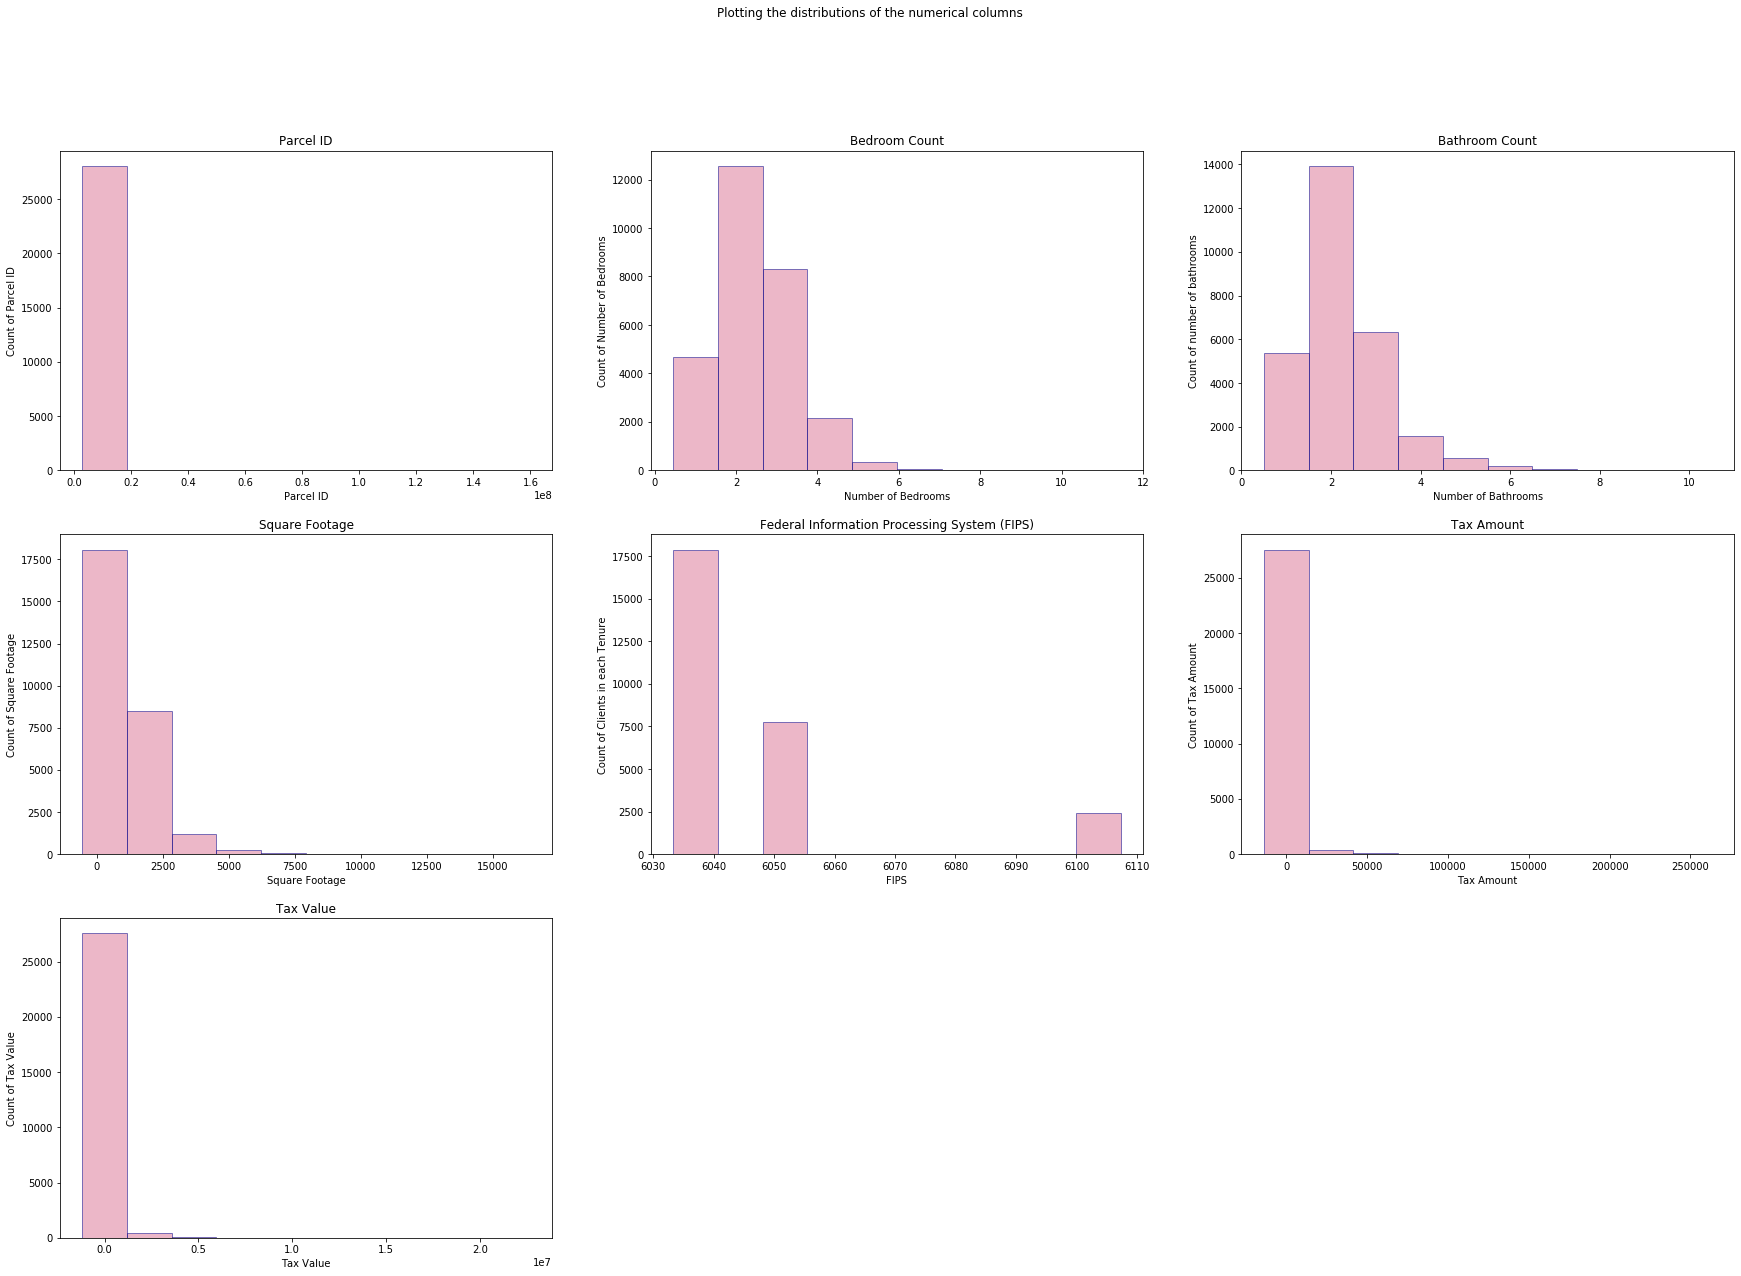

In [7]:
plt.figure(figsize=(30, 20))

plt.suptitle("Plotting the distributions of the numerical columns")
# row, columns, index
plt.subplot(3, 3, 1)
plt.hist(df.parcelid, align='left', edgecolor='darkblue', alpha=0.5, color='palevioletred')
plt.title('Parcel ID')
plt.xlabel("Parcel ID")
plt.ylabel("Count of Parcel ID")


plt.subplot(3, 3, 2)
plt.hist(df.bedroomcnt, align='left', edgecolor='darkblue', alpha=0.5, color='palevioletred')
plt.title('Bedroom Count')
plt.xlabel("Number of Bedrooms")
plt.ylabel("Count of Number of Bedrooms")


plt.subplot(3, 3, 3)
plt.hist(df.bathroomcnt, align='left', edgecolor='darkblue', alpha=0.5, color='palevioletred')
plt.title('Bathroom Count')
plt.xlabel("Number of Bathrooms")
plt.ylabel("Count of number of bathrooms")


plt.subplot(3, 3, 4)
plt.hist(df.calculatedfinishedsquarefeet, align='left', edgecolor='darkblue', alpha=0.5, color='palevioletred')
plt.title('Square Footage')
plt.xlabel("Square Footage")
plt.ylabel("Count of Square Footage")


plt.subplot(3, 3, 5)
plt.hist(df.fips, align='left', edgecolor='darkblue', alpha=0.5, color='palevioletred')
plt.title('Federal Information Processing System (FIPS)')
plt.xlabel("FIPS")
plt.ylabel("Count of Clients in each Tenure")


plt.subplot(3, 3, 6)
plt.hist(df.taxamount, align='left', edgecolor='darkblue', alpha=0.5, color='palevioletred')
plt.title('Tax Amount')
plt.xlabel("Tax Amount")
plt.ylabel("Count of Tax Amount")

plt.subplot(3,3,7)
plt.hist(df.taxvaluedollarcnt, align='left', edgecolor='darkblue', alpha=0.5, color='palevioletred')
plt.title('Tax Value')
plt.xlabel("Tax Value")
plt.ylabel("Count of Tax Value")

In the prepare.py created, the following functions are defined:
<ul>
    <li> clean_zillow- Takes in the full dataframe from acquire.py, handles nans, renames columns and appends necessary data.
    <li> prep_zillow_data- Takes in the clean zillow data and splits into train, validate, test.
    <li> prep_split_zillow_data- This function takes in the clean data, drops the tax amount for modeling purposes and then splits the data into X/Y Train, Validate/Test.
    <li> remove_outliers_zillow- This function takes in the cleaned zillow data and handles outliers as needed.

# Explore

In [8]:
df=prepare.clean_zillow()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28073 entries, 0 to 28072
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   fips            28073 non-null  float64
 1   lot_size        28073 non-null  float64
 2   square_feet     28073 non-null  float64
 3   bedroom_count   28073 non-null  float64
 4   bathroom_count  28073 non-null  float64
 5   tax_amount      28073 non-null  float64
 6   tax_value       28073 non-null  float64
 7   county          28073 non-null  object 
dtypes: float64(7), object(1)
memory usage: 1.7+ MB


In [68]:
np.random.seed(1019)
train, validate, test = prepare.prep_zillow_data()
train.shape, validate.shape, test.shape
train.head()

,fips,lot_size,square_feet,bedroom_count,bathroom_count,tax_amount,tax_value,county
16223,6037.0,5270.0,1192.0,3.0,2.0,1055.89,54624.0,los_angeles_county
428,6111.0,5548.0,2115.0,3.0,3.0,7213.02,638000.0,ventura_county
453,6037.0,8559.0,1790.0,3.0,2.0,1536.38,89105.0,los_angeles_county
27470,6037.0,7009.0,1697.0,3.0,2.0,4506.43,219000.0,los_angeles_county
13093,6111.0,4446.0,2041.0,3.0,2.5,9707.20,779236.0,ventura_county


## Hypothesis Testing:
### 1st Hypothesis Test:
$H_0$: Homes have the same mean tax value in each county.

$H_a$: Homes in Los Angeles have a higher mean tax value than in Ventura or Orange Counties.

alpha ($\alpha$): 1 - confidence level (95% confidence level -> $\alpha = .05$)

In [65]:
n = train.shape[0]     # number of observations
degf = n - 2        # degrees of freedom: the # of values in the final calculation of a statistic that are free to vary.
conf_interval = .95 # desired confidence interval
α = 1 - conf_interval
null_hypothesis = "homes have the same mean tax value in each county."

In [81]:
x1 = train[train.county == 'los_angeles_county'].tax_value
x2 = train[train.county != 'los_angeles_county'].tax_value

In [84]:
stats.ttest_ind(x1, x2)

Ttest_indResult(statistic=-7.334247923992029, pvalue=2.3384274505540557e-13)

In [85]:
if p > α:
    print("We fail to reject the null hypothesis. The null hypothesis is that", null_hypothesis)
else:
    print("We reject the null hypothesis that", null_hypothesis)

We reject the null hypothesis that homes have the same mean tax value in each county.


### 2nd Hypothesis Test:
𝐻0 : Number of bathrooms have no correlation with tax value.

𝐻𝑎 : Homes with more bathrooms are correlated with higher tax values.

alpha ( 𝛼 ): 1 - confidence level (95% confidence level ->  𝛼=.05 )

In [95]:
n = train.shape[0]     # number of observations
degf = n - 2        # degrees of freedom: the # of values in the final calculation of a statistic that are free to vary.
conf_interval = .95 # desired confidence interval
α = 1 - conf_interval
null_hypothesis='number of bathrooms have no correlation with tax value.'

In [96]:
x = train.bathroom_count
y = train.tax_value

In [97]:
corr, p = stats.pearsonr(x, y)
corr, p

(0.514021012939429, 0.0)

In [98]:
if p >  α:
    print("We fail to reject the null hypothesis. The null hypothesis is that", null_hypothesis)
else:
    print("We reject the null hypothesis that", null_hypothesis)

We reject the null hypothesis that number of bathrooms have no correlation with tax value.


### 3rd Hypothesis Test:
𝐻0 : Number of bedrooms have no correlation with tax value.

𝐻𝑎 : Homes with more bedrooms are correlated with higher tax values.

alpha ( 𝛼 ): 1 - confidence level (95% confidence level ->  𝛼=.05 )

In [87]:
n = df.shape[0]     # number of observations
degf = n - 2        # degrees of freedom: the # of values in the final calculation of a statistic that are free to vary.
conf_interval = .95 # desired confidence interval
α = 1 - conf_interval
null_hypothesis='number of bedrooms have no correlation with tax value.'

In [88]:
x2 = df.bedroom_count
y2 = df.tax_value

In [89]:
corr, p = stats.pearsonr(x2, y2)
corr, p

(0.2807020979909201, 0.0)

In [90]:
if p >  α:
    print("We fail to reject the null hypothesis. The null hypothesis is that", null_hypothesis)
else:
    print("We reject the null hypothesis that", null_hypothesis)

We reject the null hypothesis that number of bedrooms have no correlation with tax value.


### 4th Hypothesis Test:
𝐻0 : Square footage has no correlation with tax value.

𝐻𝑎 : Homes with a higher square footage are correlated with higher tax values.

alpha ( 𝛼 ): 1 - confidence level (95% confidence level ->  𝛼=.05 )

In [91]:
n = df.shape[0]     # number of observations
degf = n - 2        # degrees of freedom: the # of values in the final calculation of a statistic that are free to vary.
conf_interval = .95 # desired confidence interval
α = 1 - conf_interval
null_hypothesis="square footage has no correlation with tax value."

In [92]:
x3 = df.square_feet
y3 = df.tax_value

In [93]:
corr, p = stats.pearsonr(x3, y3)
corr, p

(0.611763274652983, 0.0)

In [94]:
if p >  α:
    print("We fail to reject the null hypothesis. The null hypothesis is that", null_hypothesis)
elif t < 0 :
    print("We fail to reject the null hypothesis. The null hypothesis is that", null_hypothesis)
else:
    print("We reject the null hypothesis that", null_hypothesis)

We fail to reject the null hypothesis. The null hypothesis is that square footage has no correlation with tax value.


<Figure size 720x576 with 0 Axes>

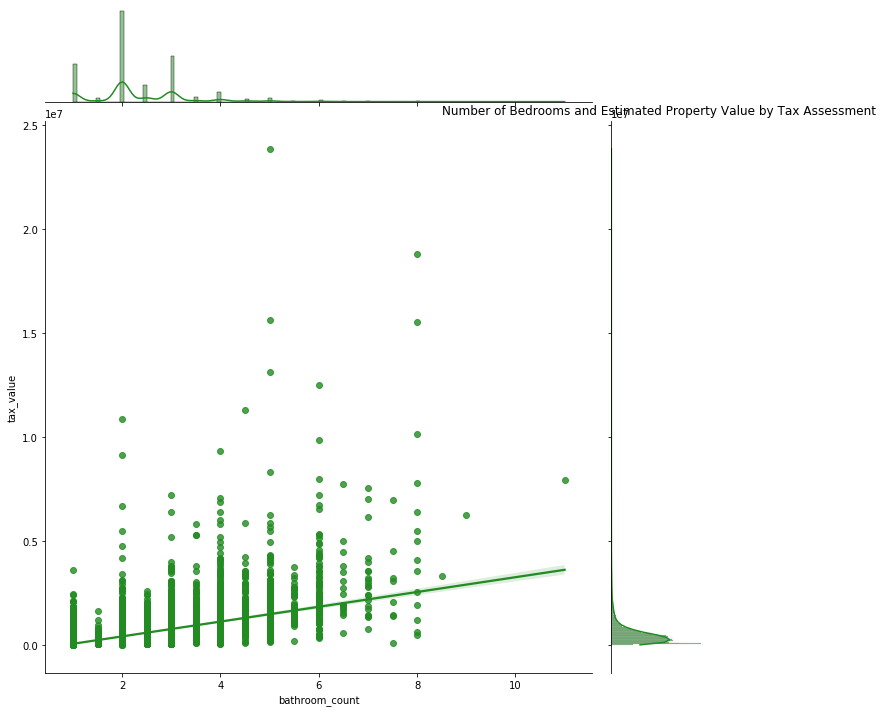

In [118]:
plt.figure(figsize=(10, 8))

#evaluating tax value assessment to number of bedrooms
sns.jointplot( "bathroom_count", "tax_value",data=train, kind='reg', height=10, color= 'ForestGreen');
plt.xlabel('Number of Bedrooms')
plt.ylabel('Estimated Property Value by Tax Assessment (in hundred thousands)')
plt.title ('Number of Bedrooms and Estimated Property Value by Tax Assessment')
plt.show()

Text(0, 0.5, 'Estimated Property Value by Tax Assessment \n (in hundred thousands)')

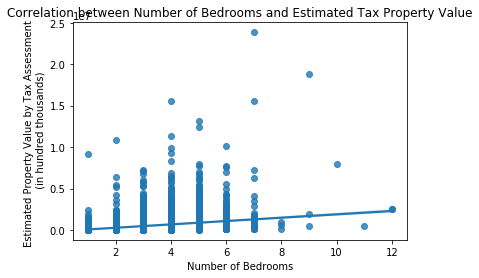

In [112]:
plt.figure(figsize=(30, 20))
#evaluating tax value assessment to number of bedrooms
sns.regplot(data= train, x='bedroom_count', y= 'tax_value')
plt.title("Correlation between Number of Bedrooms and Estimated Tax Property Value")
plt.xlabel('Number of Bedrooms')
plt.ylabel('Estimated Property Value by Tax Assessment \n (in hundred thousands)')

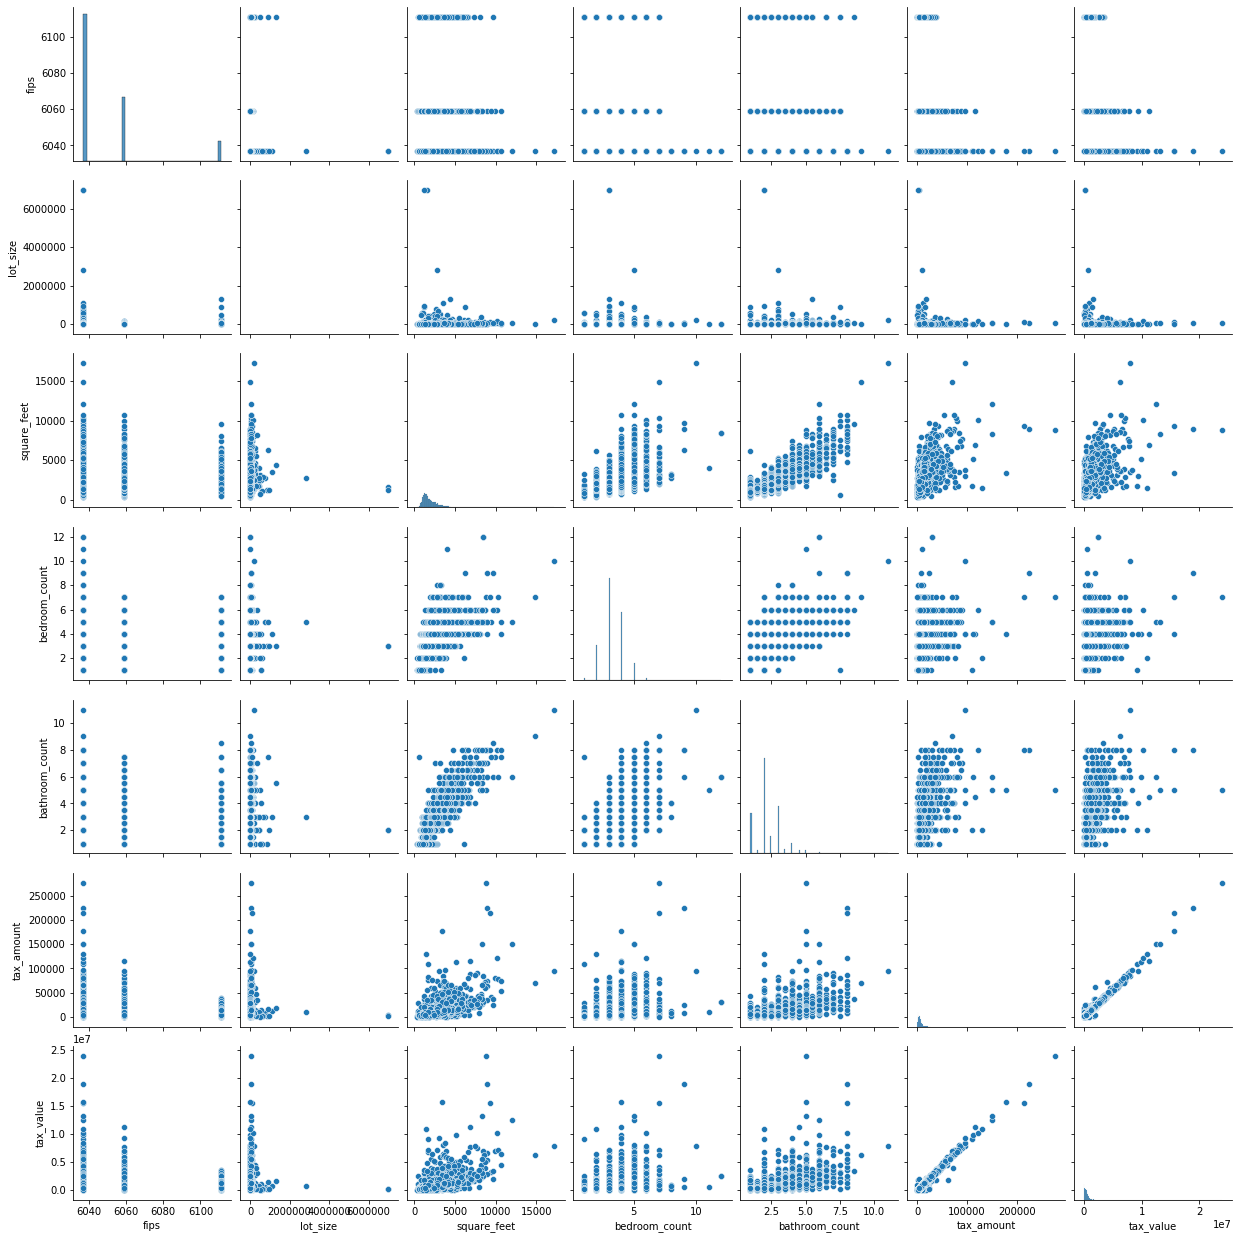

In [26]:
sns.pairplot(train)

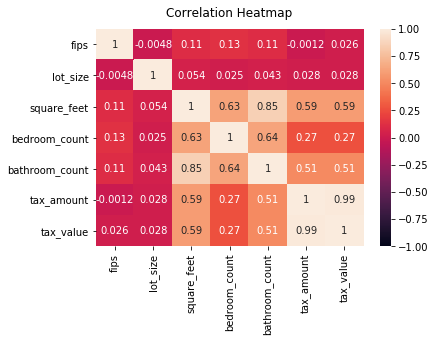

In [27]:
sns.heatmap(train.corr(),vmin=-1, vmax=1, annot=True)
plt.title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

# Feature Engineering

In [28]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
import sklearn.preprocessing
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import explained_variance_score

In [29]:
X_train, X_validate, X_test, y_train, y_validate, y_test = prepare.prep_split_zillow_data()
X_train.shape, y_train.shape

((15720, 5), (15720, 1))

In [30]:
def Robust_Scaler(X_train, X_validate, X_test):
    """
    Takes in X_train, X_validate and X_test dfs with numeric values only
    Returns scaler, X_train_scaled, X_validate_scaled, X_test_scaled dfs 
    """
    scaler = sklearn.preprocessing.RobustScaler().fit(X_train)
    X_train_scaled = pd.DataFrame(scaler.transform(X_train), index = X_train.index, columns = X_train.columns)
    X_validate_scaled = pd.DataFrame(scaler.transform(X_validate), index = X_validate.index, columns = X_validate.columns)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test), index = X_test.index, columns = X_test.columns)
    
    return scaler, X_train_scaled, X_validate_scaled, X_test_scaled

In [31]:
scaler, X_train_scaled, X_validate_scaled, X_test_scaled= Robust_Scaler(X_train, X_validate, X_test)

### Select K Best

In [32]:
def select_kbest(x, y, k):
    
    # parameters: f_regression stats test, give me k features
    f_selector = SelectKBest(f_regression, k=k)
    
    # find the top k X's correlated with y
    f_selector.fit(X_train_scaled, y_train)
    
    # boolean mask of whether the column was selected or not. 
    feature_mask = f_selector.get_support()
    
    f_feature = X_train_scaled.iloc[:,feature_mask].columns.tolist()
    
    return print(f'The two best predictors, according to k best are: {f_feature}.')

In [33]:
select_kbest(X_train_scaled, 'tax_value', 3)

The two best predictors, according to k best are: ['square_feet', 'bedroom_count', 'bathroom_count'].


### Recursive Feature Elimination

In [34]:
# initialize the ML algorithm
lm = LinearRegression()

# create the rfe object, indicating the ML object (lm) and the number of features I want to end up with. 
rfe = RFE(lm, 3)

# fit the data using RFE
rfe.fit(X_train_scaled,y_train)  

# get the mask of the columns selected
feature_mask = rfe.support_

# get list of the column names. 
rfe_feature = X_train_scaled.iloc[:,feature_mask].columns.tolist()

In [35]:
rfe_feature

['square_feet', 'bedroom_count', 'bathroom_count']

# Model

In [36]:
X_train.shape, X_validate.shape, X_test.shape, y_train.shape, y_validate.shape, y_test.shape

((15720, 5), (6738, 5), (5615, 5), (15720, 1), (6738, 1), (5615, 1))

In [37]:
X_train.head()

,fips,lot_size,square_feet,bedroom_count,bathroom_count
16223,6037.0,5270.0,1192.0,3.0,2.0
428,6111.0,5548.0,2115.0,3.0,3.0
453,6037.0,8559.0,1790.0,3.0,2.0
27470,6037.0,7009.0,1697.0,3.0,2.0
13093,6111.0,4446.0,2041.0,3.0,2.5


In [38]:
y_train.head()

,tax_value
16223,54624.0
428,638000.0
453,89105.0
27470,219000.0
13093,779236.0


In [39]:
train.tax_value.describe().apply(lambda x: format(x, 'f'))

count       15720.000000
mean       531681.202990
std        695379.524373
min         10504.000000
25%        198997.000000
50%        382798.500000
75%        632048.250000
max      23858374.000000
Name: tax_value, dtype: object

#### Baseline

In [40]:
type(y_train), type(y_validate)

(pandas.core.frame.DataFrame, pandas.core.frame.DataFrame)

In [41]:
# 1. Predict tax_value_mean
tax_pred_mean = y_train.tax_value.mean()
y_train['tax_pred_mean'] = tax_pred_mean
y_validate['tax_pred_mean'] = tax_pred_mean

# 2. compute tax_pred_median
tax_pred_median = y_train.tax_value.median()
y_train['tax_pred_median'] = tax_pred_median
y_validate['tax_pred_median'] = tax_pred_median

# 3. RMSE of tax_pred_mean
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_pred_mean) ** .5
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_pred_mean) ** (1/2)

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

# 4. RMSE of tax_pred_median
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_pred_median) ** .5
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_pred_median) ** .5
print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Mean
Train/In-Sample:  695357.41 
Validate/Out-of-Sample:  764590.6
RMSE using Median
Train/In-Sample:  711117.42 
Validate/Out-of-Sample:  780705.18


In [42]:
metric_df = pd.DataFrame(data=[{
    'model': 'mean_baseline', 
    'RMSE_validate': rmse_validate,
    'r^2_validate': explained_variance_score(y_validate.tax_value, y_validate.tax_pred_mean)}])

In [43]:
metric_df

,model,RMSE_validate,r^2_validate
0,mean_baseline,780705.183041,2.220446e-16


#### Linear Regression Model

In [44]:
# create the model object
# 
# make the thing
# 
lm = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
# 
# fit the thing
# 
lm.fit(X_train, y_train.tax_value)

# predict train
# 
# use the thing!
# 
y_train['tax_pred_lm'] = lm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_pred_lm) ** (1/2)

# predict validate
y_validate['tax_pred_lm'] = lm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_pred_lm) ** (1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  549585.9050267263 
Validation/Out-of-Sample:  582851.0133138772


In [45]:
metric_df = metric_df.append({
    'model': 'OLS Regressor', 
    'RMSE_validate': rmse_validate,
    'r^2_validate': explained_variance_score(y_validate.tax_value, y_validate.tax_pred_lm)}, ignore_index=True)
metric_df

,model,RMSE_validate,r^2_validate
0,mean_baseline,780705.183041,2.220446e-16
1,OLS Regressor,582851.013314,4.189964e-01


#### Lasso Lars Model

In [46]:
# create the model object
lars = LassoLars(alpha=1)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series!
lars.fit(X_train, y_train.tax_value)

# predict train
y_train['tax_pred_lars'] = lars.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_pred_lars) ** (1/2)

# predict validate
y_validate['tax_pred_lars'] = lars.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_pred_lars) ** (1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)


RMSE for Lasso + Lars
Training/In-Sample:  549586.0220977941 
Validation/Out-of-Sample:  582873.4273662062


In [47]:
metric_df = metric_df.append({
    'model': 'Lasso Lars', 
    'RMSE_validate': rmse_validate,
    'r^2_validate': explained_variance_score(y_validate.tax_value, y_validate.tax_pred_lars)}, ignore_index=True)
metric_df

,model,RMSE_validate,r^2_validate
0,mean_baseline,780705.183041,2.220446e-16
1,OLS Regressor,582851.013314,4.189964e-01
2,Lasso Lars,582873.427366,4.189516e-01


#### Tweedie Regressor (GLM) Model

In [48]:
# create the model object
glm = TweedieRegressor(power=1, alpha=0)


# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train, y_train.tax_value)

# predict train
y_train['tax_pred_glm'] = glm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_pred_glm) ** (1/2)

# predict validate
y_validate['tax_pred_glm'] = glm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_train.tax_value, y_train.tax_pred_glm) ** (1/2)

print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for GLM using Tweedie, power=1 & alpha=0
Training/In-Sample:  695357.406352167 
Validation/Out-of-Sample:  695357.406352167


In [49]:
metric_df = metric_df.append({
    'model': 'GLM (Poisson)', 
    'RMSE_validate': rmse_validate,
    'r^2_validate': explained_variance_score(y_validate.tax_value, y_validate.tax_pred_glm)}, ignore_index=True)

In [50]:
metric_df

,model,RMSE_validate,r^2_validate
0,mean_baseline,780705.183041,2.220446e-16
1,OLS Regressor,582851.013314,4.189964e-01
2,Lasso Lars,582873.427366,4.189516e-01
3,GLM (Poisson),695357.406352,2.220446e-16


#### Polynomial Regression

In [51]:
from sklearn.preprocessing import PolynomialFeatures
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate)
X_test_degree2 =  pf.transform(X_test)

In [52]:
# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train, y_train.tax_value)

# predict train
y_train['tax_pred_lm2'] = lm2.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_pred_lm2) ** (1/2)

# predict validate
y_validate['tax_pred_lm2'] = lm2.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_pred_lm2)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  549585.9050267263 
Validation/Out-of-Sample:  339715303721.01337


In [53]:
metric_df = metric_df.append({
    'model': 'Quadratic Model', 
    'RMSE_validate': rmse_validate,
    'r^2_validate': explained_variance_score(y_validate.tax_value, y_validate.tax_pred_lm2)}, ignore_index=True)
metric_df

,model,RMSE_validate,r^2_validate
0,mean_baseline,7.807052e+05,2.220446e-16
1,OLS Regressor,5.828510e+05,4.189964e-01
2,Lasso Lars,5.828734e+05,4.189516e-01
3,GLM (Poisson),6.953574e+05,2.220446e-16
4,Quadratic Model,3.397153e+11,4.189964e-01


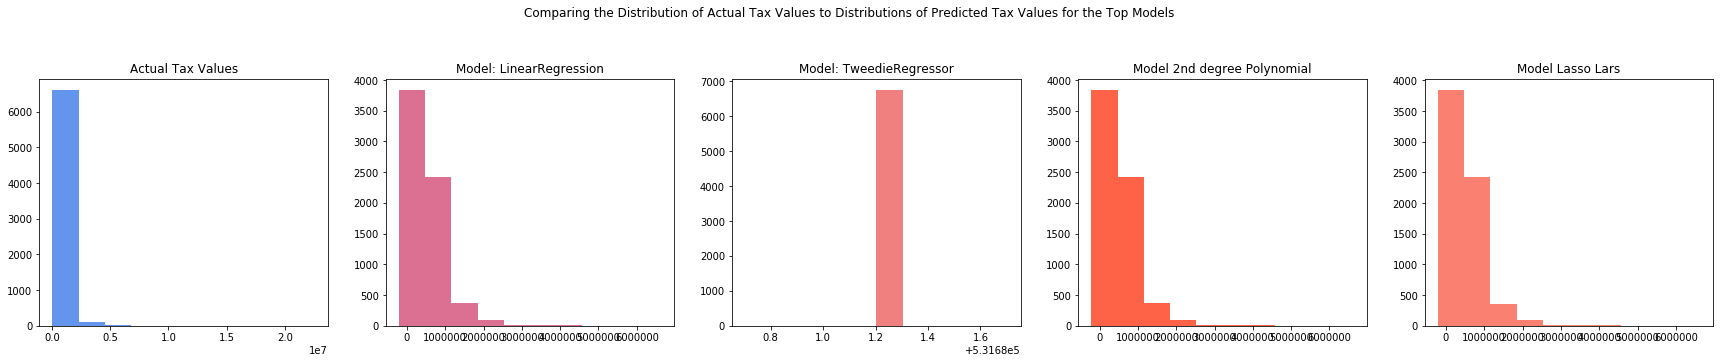

In [121]:
plt.figure(figsize=(30, 10))
# row, columns, index
plt.subplot(2, 5, 1)
plt.hist(y_validate.tax_value, color='cornflowerblue')
plt.title('Actual Tax Values')
plt.subplot(2, 5, 2)
plt.hist(y_validate.tax_pred_lm, color='palevioletred')
plt.title('Model: LinearRegression')
plt.subplot(2, 5, 3)
plt.hist(y_validate.tax_pred_glm, color='lightcoral')
plt.title('Model: TweedieRegressor')
plt.subplot(2, 5, 4)
plt.hist(y_validate.tax_pred_lm2, color='tomato')
plt.title('Model 2nd degree Polynomial')
plt.subplot(2, 5, 5)
plt.hist(y_validate.tax_pred_lars, color='salmon')
plt.title('Model Lasso Lars')


plt.suptitle("Comparing the Distribution of Actual Tax Values to Distributions of Predicted Tax Values for the Top Models")

plt.show()

#### Takeaway: The tweedie regressor model performs closest to the baseline.

In [55]:
y_test = pd.DataFrame(y_test)

# predict on test
y_test['tax_pred_glm'] = glm.predict(X_test)

# evaluate: rmse
rmse_test = mean_squared_error(y_test.tax_value, y_test.tax_pred_glm) ** (1/2)

print("RMSE for GLM Model using LinearRegression\nOut-of-Sample Performance: ", rmse_test)

RMSE for GLM Model using LinearRegression
Out-of-Sample Performance:  648058.7413728263


Text(0, 0.5, 'Count of Tax Values')

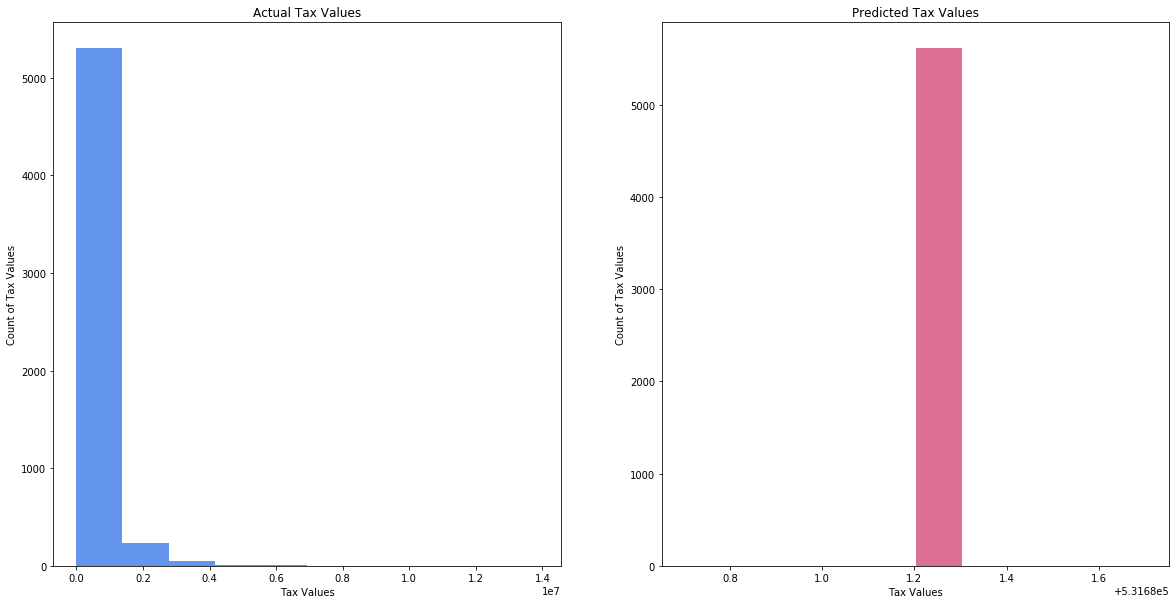

In [56]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.hist(y_test.tax_value, color='cornflowerblue')
plt.title('Actual Tax Values')
plt.xlabel("Tax Values")
plt.ylabel("Count of Tax Values")
plt.subplot(1, 2, 2)
plt.hist(y_test.tax_pred_glm, color='palevioletred')
plt.title('Predicted Tax Values')
plt.xlabel("Tax Values")
plt.ylabel("Count of Tax Values")

# Overall Tax Rate

In [57]:
df['tax_rate'] = round(((df.tax_amount / df.tax_value) * 100),2)
df.head()

,fips,lot_size,square_feet,bedroom_count,bathroom_count,tax_amount,tax_value,county,tax_rate
0,6037.0,5672.0,1316.0,3.0,2.0,2627.48,205123.0,los_angeles_county,1.28
1,6037.0,8284.0,1458.0,3.0,2.0,2319.90,136104.0,los_angeles_county,1.70
2,6037.0,6707.0,1421.0,2.0,1.0,543.69,35606.0,los_angeles_county,1.53
3,6059.0,4975.0,2541.0,4.0,3.0,9819.72,880456.0,orange_county,1.12
4,6037.0,5000.0,1491.0,3.0,2.0,1399.27,107110.0,los_angeles_county,1.31


In [124]:
grouped = df.groupby(df.county)
la_county= grouped.get_group("los_angeles_county")
v_county= grouped.get_group("ventura_county")
o_county= grouped.get_group("orange_county")

Text(0, 0.5, 'Count of Tax Rate')

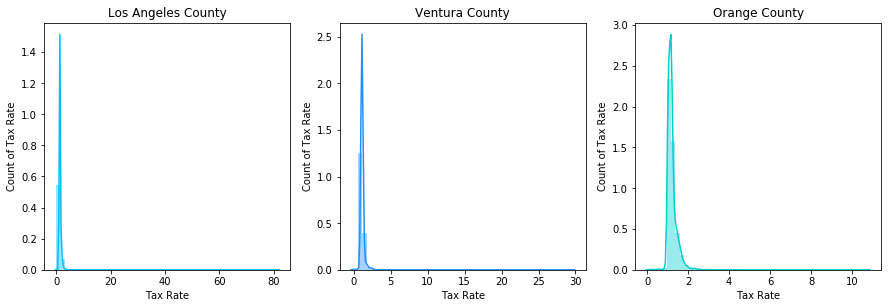

In [125]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 3, 1)
sns.distplot(la_county.tax_rate, color="deepskyblue")
plt.title('Los Angeles County')
plt.xlabel("Tax Rate")
plt.ylabel("Count of Tax Rate")

plt.subplot(2, 3, 2)
sns.distplot(v_county.tax_rate, color='dodgerblue')
plt.title('Ventura County')
plt.xlabel("Tax Rate")
plt.ylabel("Count of Tax Rate")
plt.subplot(2, 3, 3)
sns.distplot(o_county.tax_rate, color="DarkTurquoise")
plt.title('Orange County')
plt.xlabel("Tax Rate")
plt.ylabel("Count of Tax Rate")

In [129]:
la_county.tax_rate.mean(), v_county.tax_rate.mean(), o_county.tax_rate.mean()

(1.408764811088739, 1.182332923329231, 1.2073068974425338)

In [130]:
la_county.tax_rate.median(), v_county.tax_rate.median(), o_county.tax_rate.median()

(1.26, 1.12, 1.15)

# Conclusion and Recommendations

The best 3 predictors for tax value are number of bedrooms, bathrooms and square footage according to KBest and RFE.
The best model for the data is the Tweedie Regressor which performed within 0.89 of the mean baseline. The worst performing model is the polynomial which performed within 4.41 of the baseline.
Although the Tweedie Regressor performs the best, it is still well below the baseline and the original data set has over 1.3 million rows while the cleaned data frame has about 30,000 it is not an wide scale reprentation of each county.

If more data and time were available, investigating number of stories, presence of hoa, and the combination of bedrooms and bathrooms would be good to investigate as features for predicting tax value.